_Instructions and dataset taken from IBM's [Python Project for Data Engineering](https://www.coursera.org/learn/python-project-for-data-engineering) from Coursera_

# Objectives
- Read CSV, JSON, and XML file types.
- Extract the required data from the different file types.
- Transform data to the required format.
- Save the transformed data in a ready-to-load format, which can be loaded into an RDBMS.

# Prerequisite Steps
## 1.  Gather the data files

```bash
wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0221EN-SkillsNetwork/labs/module%206/Lab%20-%20Extract%20Transform%20Load/data/source.zip
```

> [!NOTE]
> In case of unavailability, a snapshot of source.zip is also available in the root directory.
> Date of snapshot: `2025 Mar 23`

## 2. Unzip the downloaded file into a directory named `source`

```bash
unzip source.zip -d source
```

After extraction, the `source` directory is expected to have three(3) CSV files, three(3) JSON files, and three(3) XML files.
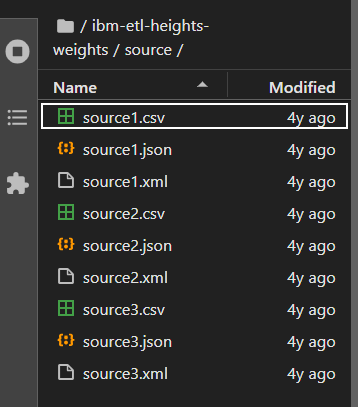

## 3. Install required libraries

```bash
python -m pip install -r requirements.txt
```

Import the necessary libraries

In [118]:
# for iterating to files in a directory
import glob 

# for data frame compilation and utilities
import pandas as pd 

# for parsing XML files
import xml.etree.ElementTree as ET 

# for log timestamps
from datetime import datetime 

# for deleting the log file and output file, if existing, before the whole ETL process is run
import os

Define some constants to be used for the rest of the notebook:

`TARGET_OUTPUT_FILE`: filename of output file

`LOG_FILE`: filename of event log file

In [119]:
TARGET_OUTPUT_FILE = "transformed_data.csv"
LOG_FILE = "log_file.txt"

Delete target output file and log file, if existing, to start each run with a clean slate

In [120]:
if os.path.exists(TARGET_OUTPUT_FILE):
    os.remove(TARGET_OUTPUT_FILE)

if os.path.exists(LOG_FILE):
    os.remove(LOG_FILE)

# Project Task 1: Define logging method
Develop a logging method `log()` that logs a message prefixed with a timestamp and appends it to the file with filename `LOG_FILE` previously defined.

In [121]:
def log(msg):
    timestamp_format = "%Y-%h-%d-%H:%M:%S"
    now = datetime.now()
    timestamp_str = now.strftime(timestamp_format)

    with open(LOG_FILE, "a") as f:
        log_str = timestamp_str + "," + msg + "\n"
        f.write(log_str)

# Project Task 2: Define extract methods
Develop extract methods for the different file formats to be processed in the dataset.


## Extracting from CSV files
**CSV** means comma-separated values. Taking a closer look at one of the input CSV files, we see that the first line contains names of the headers/columns. The headers are then immediately followed by values separated by commas:

In [122]:
# Print contents of one of the input CSV files:
with open('source/source1.csv', 'r') as file:
    print(file.read())

name,height,weight
alex,65.78,112.99
ajay,71.52,136.49
alice,69.40,153.03
ravi,68.22,142.34
joe,67.79,144.30



Pandas `read_csv()` method can be used straightforwardly to output a dataframe. This useful method also is able to get the column names from the header.

In [123]:
def extract_from_csv(file_to_process):
    log(f"In extract_from_csv(): Extracting from file '{file_to_process}'")
    dataframe = pd.read_csv(file_to_process)
    return dataframe

Calling the method above produces a dataframe that looks like:

In [124]:
print(extract_from_csv('source/source1.csv'))

    name  height  weight
0   alex   65.78  112.99
1   ajay   71.52  136.49
2  alice   69.40  153.03
3   ravi   68.22  142.34
4    joe   67.79  144.30


## Extracting from JSON files
**JSON** means Javascript Object Notation and is a human-readable open standard file format and data interchange format. Generally comprised of key and value pairs (not dissimilar to a Python Dictionary), the values can be single values or a list.
Sample from one of the input JSON files are shown below:

In [125]:
# Print contents of one of the input JSON files:
with open('source/source1.json', 'r') as file:
    print(file.read())

{"name":"jack","height":68.70,"weight":123.30}
{"name":"tom","height":69.80,"weight":141.49}
{"name":"tracy","height":70.01,"weight":136.46}
{"name":"john","height":67.90,"weight":112.37}



Similar to extracting CSV files, Pandas also has a straightforward method `read_json`.

In [126]:
def extract_from_json(file_to_process):
    log(f"In extract_from_json(): Extracting from file '{file_to_process}'")
    dataframe = pd.read_json(file_to_process, lines=True)
    return dataframe

Calling the method above produces a dataframe that looks like:

In [127]:
print(extract_from_json('source/source1.json'))

    name  height  weight
0   jack   68.70  123.30
1    tom   69.80  141.49
2  tracy   70.01  136.46
3   john   67.90  112.37


## Extracting from XML files
**XML** or the Extensible Markup Language is a markup language and file format used for data exchange. It looks similar to HTML but instead ofuses custom-defined tags instead of pre-defined tags ones. This format is both human-readable and machine-readable.
Shown below is a sample from one of our input XML files:

In [128]:
# Print contents of one of the input XML files:
with open('source/source1.xml', 'r') as file:
    print(file.read())

<?xml version="1.0" encoding="UTF-8"?>
<data>
   <person>
      <name>simon</name>
      <height>67.90</height>
      <weight>112.37</weight>
   </person>
   <person>
      <name>jacob</name>
      <height>66.78</height>
      <weight>120.67</weight>
   </person>
   <person>
      <name>cindy</name>
      <height>66.49</height>
      <weight>127.45</weight>
   </person>
   <person>
      <name>ivan</name>
      <height>67.62</height>
      <weight>114.14</weight>
   </person>
</data>


We see in the above sample that each node in the XML tree corresponds to a `person`, and that each person has a `name`, `height`, and `weight`.

- First, get the tree object using `xml.etree.ElementTree`'s `parse()` method
- Next, we get the tree's root with the `getroot()` method
- From the root, we can traverse the tree in a loop as shown in the succeeding code block
- Each `person` node parsed yields one(1) row which we store to a dictionary
- Compile each parsed row into a list of dicts `rows_list`
- Finally after all XML `person` nodes have been processed, create a Pandas DataFrame from `rows_list`

In [129]:
def extract_from_xml(file_to_process):
    log(f"In extract_from_xml(): Extracting from file '{file_to_process}'")
    rows_list = []
    tree = ET.parse(file_to_process)
    root = tree.getroot()
    for person in root:
        name = person.find("name").text
        height = float(person.find("height").text)
        weight = float(person.find("weight").text)

        rows_list.append({"name":name, "height":height, "weight":weight})
    return pd.DataFrame.from_dict(rows_list)

Calling the method above produces a dataframe that looks like:

In [130]:
print(extract_from_xml('source/source1.xml'))

    name  height  weight
0  simon   67.90  112.37
1  jacob   66.78  120.67
2  cindy   66.49  127.45
3   ivan   67.62  114.14


## Extract all inputs
After all file types have an extract method, let's create a main `extract()` method that calls all of them in turn to return a single consolidated Pandas DataFrame.

Note that the indices in the partial dataframes shown previously restart from zero every time. To properly index the resulting extracted data frame, it is important to set the `ignore_index` argument to True when Pandas `concat()` is called.

In [131]:
def extract():
    log("In extract(): started")
    # Initialize list of extracted dataframes
    # to be populated as the script goes through the dataset files
    extracted_dfs_list = []

    # Process all CSV files
    log("In extract(): start processing CSV files")
    for csvfile in glob.glob("source/*.csv"):
        extracted_dfs_list.append(extract_from_csv(csvfile))
    log("In extract(): done processing CSV files")

    # Process all JSON files
    log("In extract(): start processing JSON files")
    for jsonfile in glob.glob("source/*.json"):
        extracted_dfs_list.append(extract_from_json(jsonfile))
    log("In extract(): done processing JSON files")

    # Process all XML files
    log("In extract(): start processing XML files")
    for xmlfile in glob.glob("source/*.xml"):
        extracted_dfs_list.append(extract_from_xml(xmlfile))
    log("In extract(): done processing XML files")

    # Concatenate all dataframes in the extracted_dfs_list
    # into a single DataFrame
    # Note that ignore_index is set to True so that the index is rebuilt with properly incrementing values
    extracted_data = pd.concat(extracted_dfs_list, ignore_index=True)

    log("In extract(): ended")
    return extracted_data

Afterwards, let's call the `extract()` method to produce the extracted dataframe `extracted_data` from all of the available input files.

In [132]:
log("ETL Job Started")
extracted_data = extract()

Let's take a peek at our data after extraction:

In [133]:
print(extracted_data.info())
print('\n')
print(extracted_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    39 non-null     object 
 1   height  39 non-null     float64
 2   weight  39 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB
None


    name  height  weight
0   alex   65.78  112.99
1   ajay   71.52  136.49
2  alice   69.40  153.03
3   ravi   68.22  142.34
4    joe   67.79  144.30


After extraction, we have 39 extracted data entries.

The exercise did not call for removal of duplicates, so we assume at this point that each entry is for a different person (even if they have the same name, height and weight).

# Project Task 3: Define the Transform method

The height values in our dataset are in inches _(in.)_, while the weight values are in pounds _(lbs)_. The exercise material states that they should be converted to meters _(m)_ and kilograms _(kg)_, respectively.

Below is the `transform()` method:

In [134]:
def transform(data):
    log("In transform(): started")
    # Convert all Height values from in. to m
    METERS_PER_INCH = 0.0254
    data['height'] = round(data.height*METERS_PER_INCH, 2)

    # Convert all Weight values from lb to kg
    KG_PER_LB = 0.45359237
    data['weight'] = round(data.weight*KG_PER_LB, 2)

    log("In transform(): ended")
    return data

Afterwards, let's call the `transform()` method using the `extracted_data` as input.

In [135]:
transformed_data = transform(extracted_data)

Let's look at the first few rows to see if the transformation was done properly:

In [136]:
print('\n')
print(transformed_data.head())



    name  height  weight
0   alex    1.67   51.25
1   ajay    1.82   61.91
2  alice    1.76   69.41
3   ravi    1.73   64.56
4    joe    1.72   65.45


# Project Task 4: Define the Load method
For the last task, we need to load the extracted and transformed data into a CSV file, which can be in turn loaded into a database. The loading to CSV file is easily done using Pandas `to_csv()` method.

The filename for the output CSV file was previously defined as `TARGET_OUTPUT_FILE`.


In [137]:
def load_data(target_file, transformed_data):
    log(f"In load_data(): Loading data to file '{target_file}'")
    transformed_data.to_csv(target_file)
    log(f"In load_data(): Done loading data to file '{target_file}'")



All that's left to do is to call the `load_data()` method specifying the output filename as `TARGET_OUTPUT_FILE` and the `transformed_data` data frame as the input.

In [138]:
load_data(TARGET_OUTPUT_FILE, transformed_data)
log("ETL Job Ended\n")

# Checking the output file and logs
Shown below are the contents of the output file of the ETL process.

In [139]:
with open(TARGET_OUTPUT_FILE) as out_file:
    print(out_file.read())

,name,height,weight
0,alex,1.67,51.25
1,ajay,1.82,61.91
2,alice,1.76,69.41
3,ravi,1.73,64.56
4,joe,1.72,65.45
5,alex,1.67,51.25
6,ajay,1.82,61.91
7,alice,1.76,69.41
8,ravi,1.73,64.56
9,joe,1.72,65.45
10,alex,1.67,51.25
11,ajay,1.82,61.91
12,alice,1.76,69.41
13,ravi,1.73,64.56
14,joe,1.72,65.45
15,jack,1.74,55.93
16,tom,1.77,64.18
17,tracy,1.78,61.9
18,john,1.72,50.97
19,jack,1.74,55.93
20,tom,1.77,64.18
21,tracy,1.78,61.9
22,john,1.72,50.97
23,jack,1.74,55.93
24,tom,1.77,64.18
25,tracy,1.78,61.9
26,john,1.72,50.97
27,simon,1.72,50.97
28,jacob,1.7,54.73
29,cindy,1.69,57.81
30,ivan,1.72,51.77
31,simon,1.72,50.97
32,jacob,1.7,54.73
33,cindy,1.69,57.81
34,ivan,1.72,51.77
35,simon,1.72,50.97
36,jacob,1.7,54.73
37,cindy,1.69,57.81
38,ivan,1.72,51.77



We can also check the contents of the log file after the whole ETL process:

In [140]:
with open(LOG_FILE) as log_file:
    print(log_file.read())

2025-Mar-24-14:35:56,In extract_from_csv(): Extracting from file 'source/source1.csv'
2025-Mar-24-14:35:56,In extract_from_json(): Extracting from file 'source/source1.json'
2025-Mar-24-14:35:56,In extract_from_xml(): Extracting from file 'source/source1.xml'
2025-Mar-24-14:35:56,ETL Job Started
2025-Mar-24-14:35:56,In extract(): started
2025-Mar-24-14:35:56,In extract(): start processing CSV files
2025-Mar-24-14:35:56,In extract_from_csv(): Extracting from file 'source\source1.csv'
2025-Mar-24-14:35:56,In extract_from_csv(): Extracting from file 'source\source2.csv'
2025-Mar-24-14:35:56,In extract_from_csv(): Extracting from file 'source\source3.csv'
2025-Mar-24-14:35:56,In extract(): done processing CSV files
2025-Mar-24-14:35:56,In extract(): start processing JSON files
2025-Mar-24-14:35:56,In extract_from_json(): Extracting from file 'source\source1.json'
2025-Mar-24-14:35:56,In extract_from_json(): Extracting from file 'source\source2.json'
2025-Mar-24-14:35:56,In extract_from_jso

# Acknowledgements
## Course Instructors
- Ramesh Sannareddy
- Joseph Santarcangelo
- Abhishek Gagneja
## Course Offered By
* [IBM Skills Network](https://www.coursera.org/partners/ibm-skills-network)